In [117]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
import torchvision
import matplotlib.pyplot as plt
import numpy
from torch.utils.data import Dataset, DataLoader

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [118]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [119]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [120]:
res = 1024
input_dim = (res,res)
input_size  = res*res   # images are 32x32 pixels
output_size = 9      # there are 10 classes

def load_train_dataset():
    data_path = 'E:/Users/spectR/Desktop/%projects/mlai/tai wai/IsingML/images/'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.Compose([
            #transforms.Resize(input_dim),
            transforms.ToTensor()
            ])
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=True
    )
    return train_loader

def load_test_dataset():
    data_path = 'E:/Users/spectR/Desktop/%projects/mlai/tai wai/IsingML/images/'
    test_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.Compose([
            #transforms.Resize(input_dim),
            transforms.ToTensor()
            ])
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=True
    )
    return test_loader
'''
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                       #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                       #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=100, shuffle=True)
'''

"\ntrain_loader = torch.utils.data.DataLoader(\n    datasets.CIFAR10('../data', train=True, download=True,\n                   transform=transforms.Compose([\n                       transforms.ToTensor()\n                       #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))\n                   ])),\n    batch_size=64, shuffle=True)\n\ntest_loader = torch.utils.data.DataLoader(\n    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([\n                       transforms.ToTensor()\n                       #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))\n                   ])),\n    batch_size=100, shuffle=True)\n"

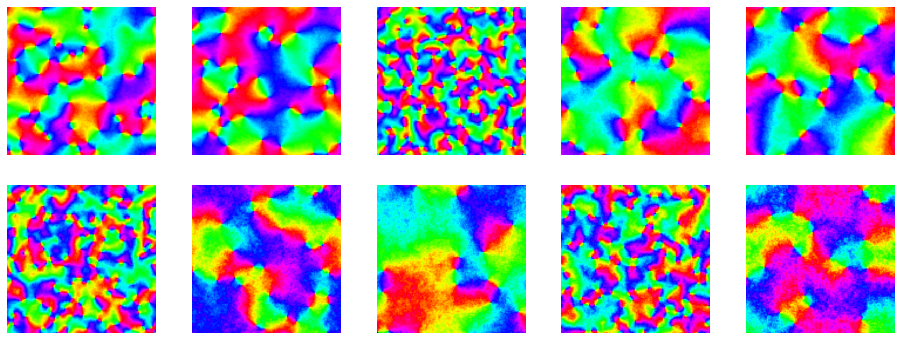

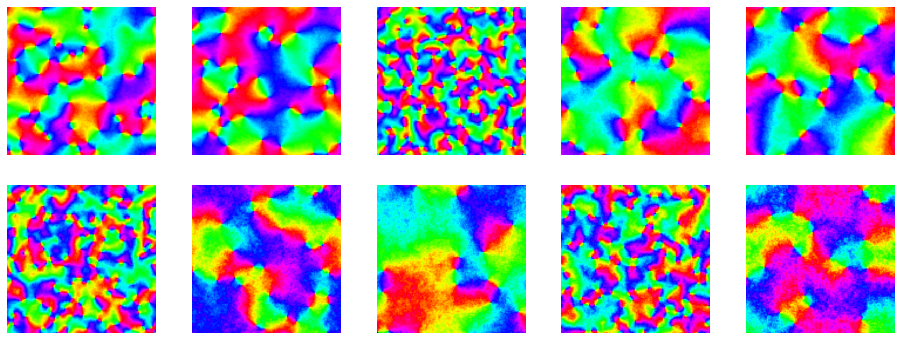

In [121]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = (load_train_dataset()).dataset.__getitem__(i)
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.axis('off');

plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = (load_test_dataset()).dataset.__getitem__(i)
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.axis('off');

In [154]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=25)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=25)
        self.conv3 = nn.Conv2d(n_feature, n_feature, kernel_size=25)
        self.conv4 = nn.Conv2d(n_feature, n_feature, kernel_size=8)
        self.fc1 = nn.Linear(n_feature*50*50, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        # F here is the library of functionals
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*50*50)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [155]:
accuracy_list = []

def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(load_train_dataset()):
        # send to device
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(load_train_dataset().dataset),
                100. * batch_idx / len(load_train_dataset()), loss.item()))
            
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in load_test_dataset():
        # send to device
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(load_test_dataset().dataset)
    accuracy = 100. * correct / len(load_test_dataset().dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(load_test_dataset().dataset),
        accuracy))

In [156]:
# Training settings 
n_features = 10 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 5):
    train(epoch, model_cnn)
    test(model_cnn)



Number of parameters: 1400750


RuntimeError: CUDA out of memory. Tried to allocate 146.00 MiB (GPU 0; 6.00 GiB total capacity; 4.38 GiB already allocated; 70.36 MiB free; 4.42 GiB reserved in total by PyTorch)

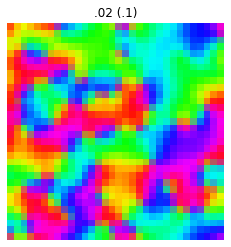

In [53]:
categories = ['.1', '.01', '.2', '.02', '.5', '.05', '1', '2', '5']

def show_predictions(rows=10, columns = 10):
    y_pred = []
    y_true = []
    x = []
    maxtoshow = rows * columns
    
    i = 0
    for data, target in load_test_dataset():
        if i>=maxtoshow:
            break
        data, target = data.to(device), target.to(device)
        output = model_cnn(data)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        x.append(data.view(-1,3,32,32)[0].permute(1, 2, 0).cpu())
        y_pred.append(pred)
        y_true.append(target)
        i = i + 1
        

    ii = 0
    plt.figure(figsize=(32, 32))
    for i in range(len(x)):
        if ii>=maxtoshow:
            break
        plt.subplot(rows, columns, ii+1)
        plt.axis('off')
        plt.imshow(x[i].numpy())
        plt.title("%s (%s)" % (categories[y_pred[i][0]], categories[y_true[i][0]]))
        ii = ii + 1
    plt.tight_layout()

show_predictions()